# Imports

In [1]:
import sys
sys.path.append('../..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.cleaning import prep_high_school_dataframe
from src.cleaning import isolate_numeric_columns, isolate_numeric_rates, filter_cwoption_special_ed
from src.cps_model import print_cv_results

from sklearn.model_selection import cross_val_predict

%load_ext autoreload
%autoreload 2

# Preprocessing

The preprocessing is handled by the methods in the cleaning.py file held in the src folder.

In [2]:
sy_1819_hs = prep_high_school_dataframe('../../data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1819.csv',
                     '../../data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1819.csv')

0 Student Count
2 schools
15     ENGLEWOOD STEM HS
582       YCCS - VIRTUAL
Name: Short_Name_sp, dtype: object
All 0 Student Count Schools Dropped
0 Graduation Rate
2 schools
261    PATHWAYS - AVONDALE HS
343     NORTHSIDE LEARNING HS
Name: Short_Name_sp, dtype: object
##########
NA Graduation Rates
38 schools
All 0/NA Graduation Rate Schools Dropped


# Note on Validation Strategy


This project works with a small sample size. There are only 134 high schools with graduation rates in the dataset. With a larger sample size, I would reserve a holdout set for model validation.  If I were to reserve 20% of the dataset, that would result in less than 30 data points to judge the model.  With such a small set, I would not be confident that the holdout score would be representative of performance on new data.  

Instead, I will use cross-validation, with `k=10`. This will allow for each model to train on over 100 schools. The average score across the 13 or so schools in each holdout will give a good idea of how generalizable the model is across the dataset.  


After the split, there are 27 schools held out in the test set.   I will use a cross val of 4 on the training set to assign a similar number of schools to each fold (~26).

# Modeling on the 4 Main Networks: 14, 15, 16, 17

To begin, I will create a model on the 4 main networks in CPS.  I made this decision because the schools in the other networks in the data set may have different objectives, and graduation rate may be deemphasized as a metric for school success. 

In [3]:
main_networks_1819 = prep_high_school_dataframe('../../data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1819.csv',
                     '../../data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1819.csv',
                                               isolate_main_nw=True)

0 Student Count
2 schools
15     ENGLEWOOD STEM HS
582       YCCS - VIRTUAL
Name: Short_Name_sp, dtype: object
All 0 Student Count Schools Dropped
0 Graduation Rate
2 schools
261    PATHWAYS - AVONDALE HS
343     NORTHSIDE LEARNING HS
Name: Short_Name_sp, dtype: object
##########
NA Graduation Rates
38 schools
All 0/NA Graduation Rate Schools Dropped


In [4]:
# After isolating the main networks, there are only 68 schools left in the dataset.
main_networks_1819['Network'].shape

(68,)

# FSM: Mean Prediction

## Mean

For a first simple model, I predict the mean of the graduation rates using a DummyRegressor.

In [5]:
grad_rates = main_networks_1819['Graduation_Rate_School']
main_nw_features = main_networks_1819.drop('Graduation_Rate_School', axis=1)

In [6]:
main_networks_1819[['Network', 'School_Type']]

,Network,School_Type
5,Network 15,Citywide-Option
9,Network 17,Military academy
23,Network 16,Neighborhood
26,Network 14,Special Education
34,Network 17,Selective enrollment
...,...,...
627,Network 15,Neighborhood
636,Network 15,Magnet
642,Network 14,Neighborhood
643,Network 14,Neighborhood


In [7]:
from src.cps_model import cv_feature_set
from sklearn.dummy import DummyRegressor

dr = DummyRegressor(strategy='mean')
cv_feature_set(dr, main_nw_features, grad_rates)

##########Training##########
R2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
RMSE
[18.52656554 21.21163853 21.16680124 20.7829701  20.22523748 19.4474703
 21.37278005 18.86203691 21.19845656 21.01146737]
Mean RMSE:  20.38054240869311
Standard Deviation RMSE:  1.0079826149228166


##########Test##########
R2
[-5.20221350e-01 -9.27756941e-04 -1.15113924e-03 -1.21703171e-01
 -2.03572155e+00 -7.93842619e-02 -5.75188353e-01 -1.46263477e-02
 -3.46418740e-01 -1.29884999e+00]
-0.4994192668200245
RMSE
[33.21759958 11.6076853  12.30047658 17.17240936 22.96319993 27.66935415
  8.82346438 30.92988261  9.48741718 13.35744777]
Mean RMSE:  18.752893684194127
Standard Deviation RMSE:  8.737710225022257


The FSM mean RMSE is just under 19 graduation percentage units off.  The largest split RMSE is 33.218, and the smallest is 8.82.

# Linear Regression

## Simple Linear Regression

The FSM only includes one predictor: `Student_Count_Total`, which has a high relative correlation to the target.  

In [19]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
cv_feature_set(lr, main_networks_1819, grad_rates, ['Student_Count_Total'])

##########Training##########
R2
[0.21413856 0.23487189 0.23838294 0.20677489 0.20511789 0.24095914
 0.21569063 0.21495491 0.2188254  0.30587505]
0.22955913017325535
RMSE
[16.42358287 18.55416001 18.47241021 18.50997528 18.03204539 16.94321005
 18.92799955 16.7122872  18.73606126 17.50552788]
Mean RMSE:  17.881725970625308
Standard Deviation RMSE:  0.8694280409780042


##########Test##########
R2
[ -0.15377027  -0.17228578  -0.20605551   0.35896597  -1.01273454
   0.0800899    0.40117278   0.22180926   0.23584172 -15.57504072]
-1.5822007189870189
RMSE
[28.93839929 12.56206417 13.50068377 12.98173685 18.69797993 25.54369241
  5.4403101  27.08745692  7.14742464 35.86703445]
Mean RMSE:  18.776678252902425
Standard Deviation RMSE:  9.60908794955491


## Add perc_low_income_students

In [21]:
lr = LinearRegression()
cv_feature_set(lr, main_networks_1819, grad_rates, 
               ['Student_Count_Total', 'perc_Student_Count_Low_Income'])


##########Training##########
R2
[0.23553861 0.24460577 0.25131037 0.21668252 0.20816735 0.26600727
 0.22493134 0.21872107 0.23073608 0.32345047]
0.24201508424590887
RMSE
[16.19842146 18.43576015 18.31496702 18.39401438 17.9974233  16.66130432
 18.81616468 16.67215146 18.59267699 17.28248473]
Mean RMSE:  17.73653684927261
Standard Deviation RMSE:  0.8990777965495196


##########Test##########
R2
[-2.00531463e-01 -1.16553546e-01 -2.56049272e-01  3.85067734e-01
 -8.62877311e-01  1.30382292e-02  5.47775520e-01  2.47668643e-01
  1.69161137e-01 -1.66557563e+01]
-1.67290566397221
RMSE
[29.51899755 12.25981838 13.7776597  12.71469362 17.98844268 26.45825189
  4.72770016 26.63359464  7.45274609 37.0178619 ]
Mean RMSE:  18.854976659667365
Standard Deviation RMSE:  9.996241565239323


## Use All Demographic Numerical Columns

In [9]:
all_num_dem = isolate_numeric_columns(main_networks_1819, 
                                      add_grad_rates=False)\
                                .drop('Student_Count_Low_Income', axis=1)
all_num_dem.head()

,perc_low_income,Student_Count_Total,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available
5,1.000000,34,4,3,25,9,0,0,0,0,0,0,0,0
9,0.715254,295,27,18,188,100,4,0,0,0,0,3,0,0
23,0.857143,21,21,8,9,8,3,0,0,0,0,1,0,0
26,0.724444,225,225,72,54,116,51,3,0,0,0,1,0,0
34,0.822257,647,59,6,625,16,1,0,0,0,0,5,0,0


In [10]:
lr = LinearRegression()
cv_feature_set(lr, all_num_dem, grad_rates)


##########Training##########
R2
[0.35795704 0.40346882 0.3988541  0.371415   0.33818177 0.44900319
 0.40545981 0.38306894 0.42593044 0.44374324]
0.39770823580384584
RMSE
[14.84488918 16.38290038 16.41138289 16.47743541 16.453678   14.43569369
 16.47978811 14.81517916 16.06151477 15.67090347]
Mean RMSE:  15.803336507007383
Standard Deviation RMSE:  0.7674811046991299


##########Test##########
R2
[ 8.15784824e-02 -1.09607372e-01 -1.00146318e-02  5.19320631e-01
  2.58747120e-01  3.34819327e-02 -2.99977626e+00  3.27314130e-01
 -6.00706943e+00 -7.33508140e+01]
-8.125683937746663
RMSE
[25.81878832 12.2216242  12.35480651 11.24138961 11.34709359 26.18279285
 14.06017544 25.18438538 21.64343232 75.96456088]
Mean RMSE:  23.60190490926206
Standard Deviation RMSE:  18.46558557403451


In [11]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()

cv_feature_set(dt, all_num_dem, grad_rates)


##########Training##########
R2
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0
RMSE
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean RMSE:  0.0
Standard Deviation RMSE:  0.0


##########Test##########
R2
[-9.23872017e-01 -1.11462585e+01 -2.77103032e-01 -2.20144202e-01
  4.52146308e-01  3.64729625e-02 -2.10668010e-01 -1.54717007e-03
 -6.19327871e+00  3.63726164e-01]
-1.8120526228211316
RMSE
[31.86720213 26.44376783 14.80463248 17.96138716 10.05051527 28.05978312
  5.83511537 30.82809479 24.67552769 10.0198137 ]
Mean RMSE:  20.054583953849253
Standard Deviation RMSE:  9.037583988144952


### Recursive Feature Elimination on Student Count Features

In [12]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from src.cleaning import STUDENT_POP_FEATURE_LIST

lr = LinearRegression()

# leave defualt n_features_to_select which selects half
rfe = RFE(lr)

dem_features = main_networks_1819[STUDENT_POP_FEATURE_LIST]

rfe.fit(dem_features, main_networks_1819['Graduation_Rate_School'])

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=None, step=1, verbose=0)

In [13]:
for dem, rank in zip(STUDENT_POP_FEATURE_LIST, rfe.ranking_):
    print(dem, rank)

Student_Count_Total 2
Student_Count_Low_Income 7
Student_Count_Special_Ed 5
Student_Count_English_Learners 6
Student_Count_Black 1
Student_Count_Hispanic 1
Student_Count_White 1
Student_Count_Asian 1
Student_Count_Native_American 1
Student_Count_Other_Ethnicity 8
Student_Count_Asian_Pacific_Islander 1
Student_Count_Multi 3
Student_Count_Hawaiian_Pacific_Islander 4
Student_Count_Ethnicity_Not_Available 1


From recursive feature elimination, the most important features for predicting graduation rates are all racial. This is suprising, since there are relatively high correlations with Total Student Count and low income students.

#### Add perc_low_income to RFE

In [14]:
STUDENT_POP_FEATURE_LIST.append('perc_low_income')

In [15]:

lr = LinearRegression()

# leave defualt n_features_to_select which selects half
rfe = RFE(lr)

dem_features = main_networks_1819[STUDENT_POP_FEATURE_LIST]

rfe.fit(dem_features, main_networks_1819['Graduation_Rate_School'])

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=None, step=1, verbose=0)

In [17]:
for dem, rank in zip(STUDENT_POP_FEATURE_LIST, rfe.ranking_):
    print(dem, rank)

Student_Count_Total 3
Student_Count_Low_Income 7
Student_Count_Special_Ed 6
Student_Count_English_Learners 8
Student_Count_Black 1
Student_Count_Hispanic 1
Student_Count_White 2
Student_Count_Asian 1
Student_Count_Native_American 4
Student_Count_Other_Ethnicity 9
Student_Count_Asian_Pacific_Islander 1
Student_Count_Multi 5
Student_Count_Hawaiian_Pacific_Islander 1
Student_Count_Ethnicity_Not_Available 1
perc_low_income 1


Adding perc_low_income bumps up low income to be considered an important feature.

### Use Demographic Rates

In [26]:
hs_1819_with_dem_rates = isolate_numeric_rates(main_networks_1819)
hs_1819_with_dem_rates['Student_Count_Total'] = main_networks_1819['Student_Count_Total']
hs_1819_with_dem_rates.head()

/Users/johnmaxbarry/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,perc_Student_Count_Low_Income,perc_Student_Count_Special_Ed,perc_Student_Count_English_Learners,perc_Student_Count_Black,perc_Student_Count_Hispanic,perc_Student_Count_White,perc_Student_Count_Asian,perc_Student_Count_Native_American,perc_Student_Count_Other_Ethnicity,perc_Student_Count_Asian_Pacific_Islander,perc_Student_Count_Multi,perc_Student_Count_Hawaiian_Pacific_Islander,perc_Student_Count_Ethnicity_Not_Available,Student_Count_Total
5,1.000000,0.117647,0.088235,0.735294,0.264706,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,34
9,0.715254,0.091525,0.061017,0.637288,0.338983,0.013559,0.000000,0.0,0.0,0.0,0.010169,0.0,0.0,295
23,0.857143,1.000000,0.380952,0.428571,0.380952,0.142857,0.000000,0.0,0.0,0.0,0.047619,0.0,0.0,21
26,0.724444,1.000000,0.320000,0.240000,0.515556,0.226667,0.013333,0.0,0.0,0.0,0.004444,0.0,0.0,225
34,0.822257,0.091190,0.009274,0.965997,0.024730,0.001546,0.000000,0.0,0.0,0.0,0.007728,0.0,0.0,647


In [27]:
lr = LinearRegression()
cv_feature_set(lr, hs_1819_with_dem_rates, grad_rates)

##########Training##########
R2
[0.50525661 0.49585437 0.51024736 0.47461069 0.45888161 0.61419407
 0.50905288 0.4904473  0.53508113 0.51300208]
0.5106628106886305
RMSE
[13.03121525 15.06094489 14.81302049 15.06427471 14.87783635 12.07946122
 14.97539806 13.46428035 14.45415907 14.66290208]
Mean RMSE:  14.248349247038126
Standard Deviation RMSE:  0.9789902874286369


##########Test##########
R2
[-0.9059355   0.56346964  0.13598598  0.752534    0.33153663 -0.1649125
 -0.75221621  0.44907901 -3.13902133 -7.57538882]
-1.0304869090461533
RMSE
[37.19366125  7.66569412 11.42700746  8.06584791 10.77556983 28.74469037
  9.30607905 22.7913401  16.63438529 25.79853699]
Mean RMSE:  17.84028123530968
Standard Deviation RMSE:  9.724685416825727


Adding the rate of demographics with the total student count improved the score to the highest test set R2 yet, but they are still oberall negative R2 across the 10 folds. 

Here are the cross validation predictions.

In [32]:
y_hat_cv = cross_val_predict(lr, hs_1819_with_dem_rates, grad_rates, cv=10)

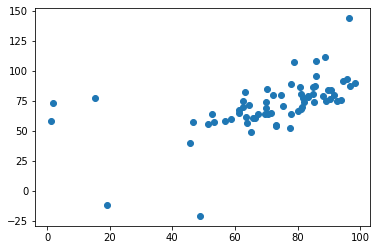

In [33]:
fig, ax = plt.subplots()
ax.scatter(grad_rates, y_hat_cv)

As the plot suggests below, the model performs the worst on the schools with true graduation rates under 20. 

Text(0.5, 1.0, 'Graduation Rate Predictions vs. Residuals\n with Linear Regression Model Including Demographic Rates')

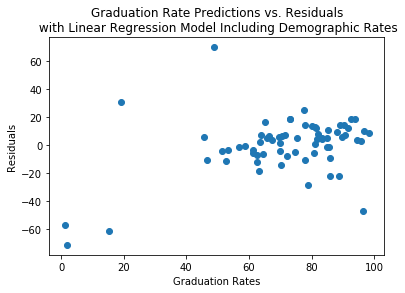

In [38]:
fig, ax = plt.subplots()
ax.scatter(grad_rates, grad_rates-y_hat_cv)
ax.set_xlabel('Graduation Rates')
ax.set_ylabel('Residuals')
ax.set_title('Graduation Rate Predictions vs. Residuals\n with Linear Regression Model Including Demographic Rates')

# Inverse Log transform target

In [16]:
y_hat_train = print_cv_results(lr,X_train, ['Student_Count_Total'], np.log(100-y_train) )

NameError: name 'X_train' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
y_hat_train_untransformed = 100 - np.e**y_hat_train

rmse = mean_squared_error(y_train, y_hat_train_untransformed, squared=False)
print(rmse)

r2 = r2_score(y_train, y_hat_train_untransformed)
print(r2)

## One Hot Encode Networks

In [ ]:
from sklearn.impute import SimpleImputer

network_imputer = SimpleImputer(strategy='constant', fill_value='missing')

X_train['Network'] = network_imputer.fit_transform(X_train[['Network']])

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder


# network_imputer = ColumnTransformer([('network_impute', SimpleImputer(strategy='constant', fill_value='missing'), ['Network'])], 
#                                          remainder='passthrough')


# network_transformer = ColumnTransformer( [('network_impute', SimpleImputer(strategy='constant', fill_value='missing'), ['Network']), 
#                                          ('network_ohe', OneHotEncoder(handle_unknown='ignore'), ['Network'])], 
#                                          remainder='passthrough')


network_ohe = ColumnTransformer([ 
                                          ('network_ohe', OneHotEncoder(handle_unknown='ignore'), ['Network'])], 
                                         remainder='passthrough')

network_pipe = make_pipeline(network_ohe, LinearRegression())

cv_cps(network_pipe, X_train, y_train, ['Student_Count_Total', 'perc_low_income', 'Network'])

Adding Network One Hot Encoded columns decreases the bias, but increases the vaiance.  There is even one negative R^2 score which is particularly worrisome.

# High Correlation 

In [ ]:
df_train.corr().iloc[-1].dropna().sort_values()

In [ ]:
df_train.corr().iloc[-1].dropna().sort_values(ascending=False)

In [ ]:
df_train[['Graduation_Rate_School', 'Student_Count_Low_Income']].corr()